In [67]:
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler

# Read the datasets
energy_df = pd.read_csv('energy_dataset.csv')


In [68]:
def check_all_zero(df):
    all_zero_column=[]
    for column in energy_df:
        all_zeros_or_null = (energy_df[column] == 0) | pd.isnull(energy_df[column])
        if all_zeros_or_null.all()==True:
            all_zero_column.append(column)
    return all_zero_column

all_cero_column = check_all_zero(energy_df)




In [69]:
def drop_column(df, columns):
    return df.drop(columns, axis=1)

energy_df =drop_column(energy_df,all_cero_column)


In [70]:
# Preprocess the data
def pre_process_totalload(df):
    df["time"] = pd.to_datetime(df["time"], utc=True)
    df.set_index('time', inplace=True)
    total_load_df = df[["total load actual"]]
    total_load_df["month"] = total_load_df.index.month
    total_load_df["weekday"] = total_load_df.index.weekday
    total_load_df["hour"] = total_load_df.index.hour
    total_load_df = pd.get_dummies(total_load_df, columns=['hour'], dtype=int)
    return total_load_df

In [71]:
total_load_df = pre_process_totalload(energy_df)
total_load_df = total_load_df.dropna()
y_df = total_load_df["total load actual"].astype('float64')
X_df = total_load_df.drop("total load actual", axis=1)

/var/folders/2_/60s36pk17lq0ltwcttxd9p7m0000gn/T/ipykernel_96696/3338687135.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_load_df["month"] = total_load_df.index.month
/var/folders/2_/60s36pk17lq0ltwcttxd9p7m0000gn/T/ipykernel_96696/3338687135.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_load_df["weekday"] = total_load_df.index.weekday
/var/folders/2_/60s36pk17lq0ltwcttxd9p7m0000gn/T/ipykernel_96696/3338687135.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

In [72]:

def pre_process(df):
    all_cero_column=check_all_zero(df)
    df= drop_column(df,all_cero_column)
    total_load_df=pre_process_totalload(df)
    print(total_load_df.isnull().values.any())
    return total_load_df


In [73]:
# Normalize the features
scaler = StandardScaler()
X_df_scaled = scaler.fit_transform(X_df)

In [74]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_df_scaled, y_df, test_size=0.33, random_state=42)


In [75]:
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l1, l2

def build_nn_model(input_shape, hidden):
    model_in = tf.keras.Input(shape=input_shape, dtype='float32')
    x = model_in
    for h in hidden:
        x = keras.layers.Dense(h, activation='relu')(x)
    mu = keras.layers.Dense(1)(x)  # Mean of the distribution
    sigma = keras.layers.Dense(1, activation=tf.nn.softplus)(x)  # Standard deviation (positive)
    dist = tfp.layers.DistributionLambda(lambda t: tfp.distributions.Normal(loc=t[0], scale=t[1]))([mu, sigma])
    model = tf.keras.Model(model_in, dist)
    return model

# Then use this function to build your model
model = build_nn_model(X_train.shape[1], [128, 64])


In [76]:
import tensorflow as tf
import tensorflow_probability as tfp
print(tf.__version__)
print(tfp.__version__)


2.12.0
0.14.0


In [77]:
# Define the model architecture
hidden_layers = [128, 64]
model = build_nn_model(X_train.shape[1], hidden_layers)

In [78]:
# Custom Loss Function and Learning Rate Scheduler
def custom_loss_function(y_true, dist):
    return -dist.log_prob(y_true)

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [79]:
from sklearn.model_selection import train_test_split
import pandas as pd
total_load_df = total_load_df.dropna()
y_df=total_load_df["total load actual"].astype('float64')
X_df=total_load_df.drop("total load actual", axis=1)

sep = '2018-01-01'
#normalize weekday and month
X_df['weekday'] = X_df['weekday'] / 6
X_df["month"] = X_df["month"]/12
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
input_shape=len(X_df.columns)

In [80]:
def negloglik(y_true, y_pred):
    return -y_pred.log_prob(y_true)

model.compile(optimizer=tf.optimizers.Adam(), loss=negloglik)
model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1)


Epoch 1/100


/Users/karansingh/anaconda3/envs/tf_prob_env/lib/python3.8/site-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


734/734 [==============================] - 5s 7ms/step - loss: 17289428.0000
Epoch 2/100
734/734 [==============================] - 5s 6ms/step - loss: 956041.1250
Epoch 3/100
734/734 [==============================] - 5s 6ms/step - loss: 437255.5000
Epoch 4/100
734/734 [==============================] - 5s 6ms/step - loss: 254246.3125
Epoch 5/100
734/734 [==============================] - 5s 7ms/step - loss: 163932.4219
Epoch 6/100
734/734 [==============================] - 5s 6ms/step - loss: 111692.0625
Epoch 7/100
734/734 [==============================] - 5s 6ms/step - loss: 78634.8516
Epoch 8/100
734/734 [==============================] - 5s 6ms/step - loss: 56500.9023
Epoch 9/100
734/734 [==============================] - 5s 6ms/step - loss: 41132.2656
Epoch 10/100
734/734 [==============================] - 5s 6ms/step - loss: 30203.1602
Epoch 11/100
734/734 [==============================] - 5s 7ms/step - loss: 22302.4121
Epoch 12/100
734/734 [==============================] - 

In [81]:
""" 
from util.neuralprobabilistic import train_nn_model
from tensorflow import keras


# Define the neural network architecture
model_in = tf.keras.Input(shape=input_shape, dtype=tf.float32)
x=model_in
#x = tf.keras.layers.Dense(hidden_neurons, activation='relu')(model_in)
mu_logsigma = tf.keras.layers.Dense(2, activation='linear')(x)
# Define a lambda function for the distribution
lf = lambda t: tfp.distributions.Normal(loc=t[:, :1], scale=tf.math.exp(t[:, 1:]))

# Create the output layer using DistributionLambda
model_out = tfp.layers.DistributionLambda(lf)(mu_logsigma)

# Create the probabilistic neural network model
model = tf.keras.Model(model_in, model_out)


keras.utils.plot_model(model, show_shapes=True,show_layer_names=True, rankdir='LR', show_layer_activations=True)
plt.show()
 """

" \nfrom util.neuralprobabilistic import train_nn_model\nfrom tensorflow import keras\n\n\n# Define the neural network architecture\nmodel_in = tf.keras.Input(shape=input_shape, dtype=tf.float32)\nx=model_in\n#x = tf.keras.layers.Dense(hidden_neurons, activation='relu')(model_in)\nmu_logsigma = tf.keras.layers.Dense(2, activation='linear')(x)\n# Define a lambda function for the distribution\nlf = lambda t: tfp.distributions.Normal(loc=t[:, :1], scale=tf.math.exp(t[:, 1:]))\n\n# Create the output layer using DistributionLambda\nmodel_out = tfp.layers.DistributionLambda(lf)(mu_logsigma)\n\n# Create the probabilistic neural network model\nmodel = tf.keras.Model(model_in, model_out)\n\n\nkeras.utils.plot_model(model, show_shapes=True,show_layer_names=True, rankdir='LR', show_layer_activations=True)\nplt.show()\n "

In [82]:
""" def custom_loss(y_true, dist):
    # Extract mean and standard deviation from the distribution
    mean = dist.loc
    std = dist.scale

    # Adjust the scale parameter as needed
    scaled_std = std * 0.1

    # Calculate the negative log-likelihood
    negloglik = -tfp.distributions.Normal(mean, std).log_prob(y_true)

    return tf.reduce_mean(negloglik)


# Compile the model with a suitable loss function
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler

# Custom Loss Function
def custom_loss_function(y_true, dist):
    return -dist.log_prob(y_true)

# Learning Rate Scheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

# Compile the model with the custom loss function and optimizer
model.compile(optimizer=Adam(learning_rate=0.001), loss=custom_loss_function)

# Learning rate scheduler callback
callback = LearningRateScheduler(scheduler)
""" 

' def custom_loss(y_true, dist):\n    # Extract mean and standard deviation from the distribution\n    mean = dist.loc\n    std = dist.scale\n\n    # Adjust the scale parameter as needed\n    scaled_std = std * 0.1\n\n    # Calculate the negative log-likelihood\n    negloglik = -tfp.distributions.Normal(mean, std).log_prob(y_true)\n\n    return tf.reduce_mean(negloglik)\n\n\n# Compile the model with a suitable loss function\nfrom tensorflow.keras.optimizers import Adam\nfrom tensorflow.keras.callbacks import LearningRateScheduler\n\n# Custom Loss Function\ndef custom_loss_function(y_true, dist):\n    return -dist.log_prob(y_true)\n\n# Learning Rate Scheduler\ndef scheduler(epoch, lr):\n    if epoch < 10:\n        return lr\n    else:\n        return lr * tf.math.exp(-0.1)\n\n# Compile the model with the custom loss function and optimizer\nmodel.compile(optimizer=Adam(learning_rate=0.001), loss=custom_loss_function)\n\n# Learning rate scheduler callback\ncallback = LearningRateScheduler

In [83]:
print(model)
print(history)

train_loss = history.history['loss']
#val_loss = history.history['val_loss']

print(train_loss)
print(history.history)

[0.13099554181098938, 0.10703859478235245, 0.09650672972202301, 0.09416446834802628, 0.0938032865524292, 0.09374179691076279, 0.09370365738868713, 0.09370510280132294, 0.09370630979537964, 0.09369474649429321]
{'loss': [0.13099554181098938, 0.10703859478235245, 0.09650672972202301, 0.09416446834802628, 0.0938032865524292, 0.09374179691076279, 0.09370365738868713, 0.09370510280132294, 0.09370630979537964, 0.09369474649429321]}


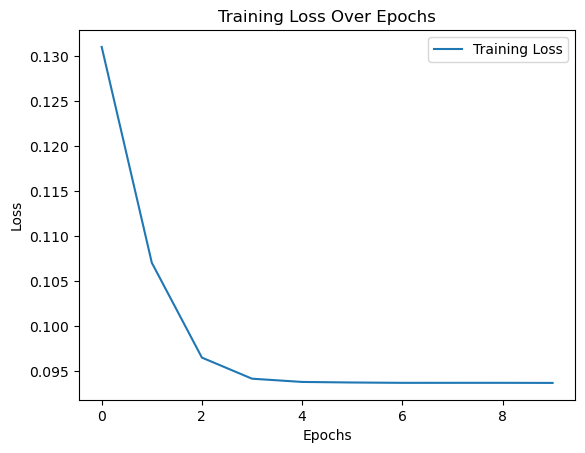

In [84]:
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


362/362 [==============================] - 1s 2ms/step


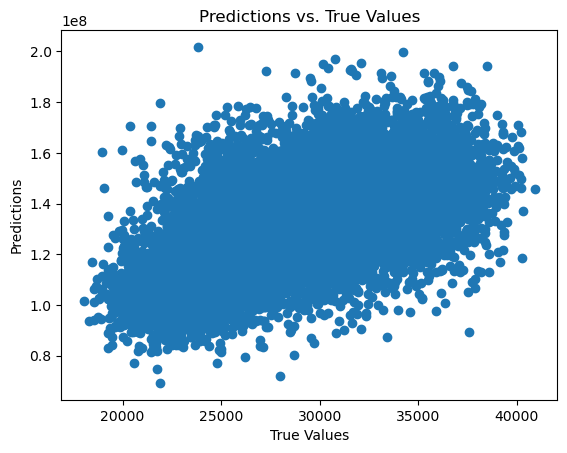

[[1.2775141e+08]
 [1.4065216e+08]
 [1.0645773e+08]
 ...
 [1.7440894e+08]
 [1.0111136e+08]
 [9.6137264e+07]]


In [85]:
predictions = model.predict(X_test)
# Apply inverse transformation to bring predictions back to original scale
predictions = predictions * std_train + mean_train

# Plot predictions vs. targets
plt.scatter(y_test, predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Predictions vs. True Values')
plt.show()
#util.plot_pred_scatter(y_test, ts_pred, figsize=figsize)
print(predictions)

In [86]:
# Create a DataFrame with the index of X_test
result_df = pd.DataFrame(index=y_test.index)

# Add columns for predictions and true values
result_df['predictions'] = predictions.flatten()  # Flatten the predictions array
result_df['true_values'] = y_test.values #

result_df

,predictions,true_values
time,,
2017-04-28 19:00:00+00:00,127751408.0,31267.0
2018-02-14 21:00:00+00:00,140652160.0,34606.0
2016-04-09 04:00:00+00:00,106457728.0,22712.0
2017-09-23 08:00:00+00:00,163761744.0,28169.0
2016-02-04 11:00:00+00:00,188299136.0,29545.0
...,...,...
2017-10-20 08:00:00+00:00,122247792.0,31341.0
2018-09-27 00:00:00+00:00,108356480.0,24320.0
2016-01-18 19:00:00+00:00,174408944.0,37724.0


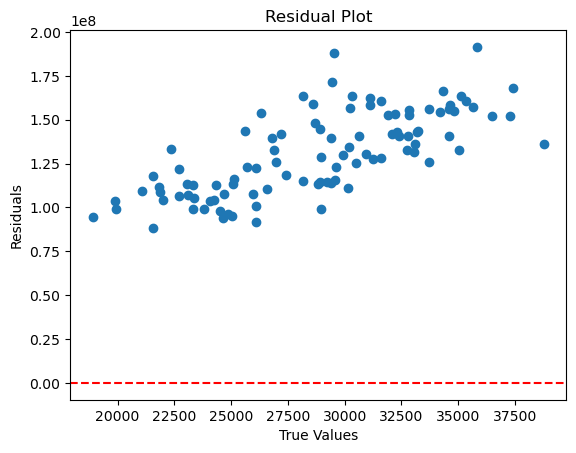

In [87]:


residuals = result_df[0:100]['predictions'] -result_df[0:100]["true_values"]
plt.scatter(result_df[0:100]["true_values"], residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('True Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()
